In [7]:
import cProfile
import sys
import itertools

import numpy as np
import pandas as pd
import scipy.signal
from scipy.signal import savgol_filter
from scipy.stats import zscore

from tqdm import tqdm

import neuroseries as nts


import time
import matplotlib.pyplot as plt
# %matplotlib qt

import seaborn as sns
import bk.load
import bk.compute
import bk.plot

import os

import pickle


In [3]:
bk.load.current_session_linux(
    base_folder='/mnt/electrophy/Gabrielle/GG-Dataset')
rip = pd.read_csv(f'{bk.load.base}/All-Rats/Billel/ripplemod.csv')
theta = pd.read_csv(f'{bk.load.base}/All-Rats/Billel/thetamod.csv')
mod = pd.merge(left=theta, right=rip, how='inner')
mod['Type'][mod['Region'] == 'CeCM'] = 'Int'


Rat : 8 on day : 6
Working with session Rat08-20130713 @ /mnt/electrophy/Gabrielle/GG-Dataset/Rat08/Rat08-20130713


/tmp/ipykernel_1292516/2248595840.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mod['Type'][mod['Region'] == 'CeCM'] = 'Int'


In [4]:
def main(base_folder, local_path):
    bk.load.current_session_linux(
        base_folder='/mnt/electrophy/Gabrielle/GG-Dataset', local_path=local_path)
    states = bk.load.states()
    neurons, metadata = bk.load.spikes()

    # For NREM_REM only for now :
    transitions_interest = ["sws", "Rem"]
    bin_epochs = [30, 12]
    n_event = 2

    print(f"Computing {transitions_interest} transitions")
    intervals, timing = bk.compute.transition(
        states, transitions_interest, epsilon=50
    )  # Find the timing of the transitions
    print(f"Found {len(intervals)} transitions")

    transition_activity = bk.compute.compute_transition_activity(
        neurons, intervals, timing, bin_epochs, n_event
    )

    return np.array(transition_activity), metadata, bin_epochs

In [45]:
def merge(batch, name, discard):
    transitions_activity = []
    metadata = []
    n_transitions = 0
    n_sessions = 0
    for i, b in batch.items():
        if i not in discard:
            #          if True:
            transitions_activity.append(np.mean(b[0], 2))
            metadata.append(b[1])
            n_transitions += b[0].shape[2]
            n_sessions += 1
            bins_epochs = b[2]

    s = np.append(0, np.cumsum(bins_epochs))[:-1]
    e = np.cumsum(bins_epochs)-1

    intervals = np.array([s, e]).T
    merged = {'name': name,
              'average_transition': np.vstack(transitions_activity),
              'metadata': pd.concat(metadata),
              'n_transitions': n_transitions,
              'n_sessions': n_sessions,
              'intervals': intervals}

    merged['metadata'].Type[merged['metadata'].Region == 'CeCM'] = 'Int'
    return merged


def plot_average_transitions(merged_activity, norm='zscore', ax=None, style='b-', shade=False):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    if norm == 'zscore':
        merged_activity = zscore(merged_activity, 1)
    ax.plot(np.nanmean(merged_activity, 0), style)

    if shade == 'std':
        x = range(len(np.mean(merged_activity, 0)))
        y1 = np.nanmean(merged_activity, 0) - \
            np.std(np.nanmean(merged_activity, 0), 0)
        y2 = np.nanmean(merged_activity, 0) + \
            np.std(np.nanmean(merged_activity, 0), 0)
        ax.fill_between(x, y1, y2)


In [33]:
nrem_rem = bk.load.batch(main, linux=True)


100%|██████████| 61/61 [02:02<00:00,  2.01s/it]

Batch finished in 122.59036707878113
Some session were not processed correctly
['Rat08-20130720', 'Rat08-20130722', 'Rat11-20150401']
4.918032786885246 %


In [34]:
discard = [
    "Rat08-20130718",
    "Rat09-20140408",
    "Rat09-20140409",
    "Rat10-20140619",
    "Rat10-20140620",
    "Rat10-20140622",
]
nrem_rem_merged = merge(nrem_rem, 'nrem_rem', discard)


In [35]:
nrem_rem_merged['metadata'] = pd.merge(
    nrem_rem_merged['metadata'], mod, how='left')


In [36]:
def make_figure(merged, stru, norm='zscore', ylimL=None, ylimR=None, ylim_violin=None, **kwargs):

    name = merged['name']
    average_transition = merged['average_transition']
    intervals = merged['intervals']
    metadata = merged['metadata']

    if 'intervals_colors' in kwargs:
        intervals_colors = kwargs['intervals_colors']
    else:
        intervals_colors = ['grey'] * len(intervals)

    fig, ax = plt.subplot_mosaic("""
                                  A
                                  A
                                 """,
                                 dpi=180)
    stru_pyr_average_theta = average_transition[(metadata['Region'] == stru)
                                                & (metadata['Type'] == 'Pyr')
                                                & (metadata['modulated'] == True)]

    stru_pyr_average_no_theta = average_transition[(metadata['Region'] == stru)
                                                   & (metadata['Type'] == 'Pyr')
                                                   & (metadata['modulated'] == False)]
    if norm == 'zscore':
        plot_average_transitions(
            stru_pyr_average_theta, norm, ax=ax['A'], style='-g')
        plot_average_transitions(
            stru_pyr_average_no_theta, norm, ax=ax['A'], style='--g')
        ax['A'].set_ylabel('Firing Rates (zscore)')
        ax['A'].set_xlabel('Normalized Time')
    else:
        plot_average_transitions(
            stru_pyr_average_theta, norm, ax=ax['A'], style='-g',shade = 'std')
        # right = ax['A'].twinx()
        plot_average_transitions(
            stru_pyr_average_no_theta, norm, ax=ax['A'], style='--g',shade = 'std')
        ax['A'].set_ylabel('Firing Rates (Hz)')
        ax['A'].set_xlabel('Normalized Time')

    if ylimL is not None:
        ax['A'].set_ylim(ylimL[0], ylimL[1])
    if ylimR is not None:
        right.set_ylim(ylimR[0], ylimR[1])

    for n, (s, e) in enumerate(intervals):
        ax['A'].axvspan(s, e, color=intervals_colors[n])

    pre = [intervals[0, 0], intervals[0, 1]]
    post = [intervals[-1, 0], intervals[-1, 1]]
    # plot_violin_pre_post(stru_pyr_average, pre, post, 'Pyr',
    #                      norm, ax=ax['B'], ylim=ylim_violin)
    # plot_violin_pre_post(stru_int_average, pre, post, 'Int',
    #                      norm, ax=ax['C'], ylim=ylim_violin)

    ax['A'].set_title((f'{name}'))
    plt.suptitle(stru)
    plt.tight_layout()
    return 0


/home/billel/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


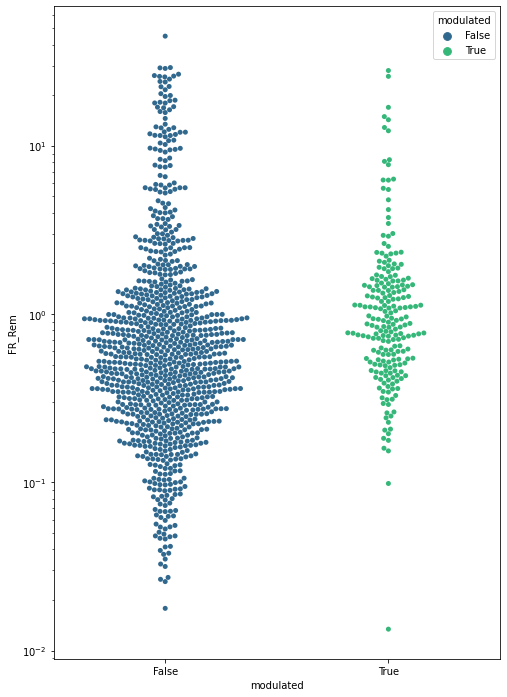

In [115]:
import seaborn as sns
modlog = mod.copy()
modlog.FR_Rem = np.log10(modlog.FR_Rem)


fig,ax = plt.subplots(1,1)
fig.set_figheight(12)
fig.set_figwidth(8)
ax.set_yscale('log')
ax = sns.swarmplot(data=mod[mod.Region == 'BLA'], x='modulated', y='FR_Rem',hue='modulated',palette='viridis')
np.nanmean(merged_activity, 0)

In [72]:
mod

,Rat,Day,Shank,Id,Region,Type,FR_Rem,MRL,Kappa,pValue,modulated,pInc,pDec,surprise
0,8,1,4,2,Hpc,Pyr,NaN,0.332516,2.699269,1.960397e-154,True,1.000000e+00,6.904731e-27,-36.043653
1,8,1,4,3,Hpc,Pyr,NaN,0.238236,2.002894,8.829184e-27,True,0.000000e+00,1.000000e+00,36.043653
2,8,1,4,4,Hpc,Int,NaN,0.335994,2.724784,1.059645e-24,True,0.000000e+00,1.000000e+00,36.043653
3,8,1,4,5,Hpc,Pyr,NaN,0.092036,0.869709,8.844135e-04,True,0.000000e+00,1.000000e+00,36.043653
4,8,1,4,6,Hpc,Pyr,NaN,0.115421,1.059451,1.213375e-03,True,0.000000e+00,1.000000e+00,36.043653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4631,11,21,14,22,Pir,Pyr,NaN,0.019159,0.223517,9.675024e-01,False,5.845857e-01,4.992895e-01,-0.157717
4632,11,21,14,23,Pir,Pyr,NaN,0.076053,0.736752,7.112604e-02,False,9.997216e-01,3.968778e-04,-7.831604
4633,11,21,14,24,Pir,Pyr,NaN,0.007252,0.096921,9.734327e-01,False,1.000000e+00,9.645276e-11,-23.061966
4634,11,21,14,25,Pir,Pyr,NaN,0.059954,0.599292,8.252885e-02,False,3.607457e-01,6.714700e-01,0.621296


207


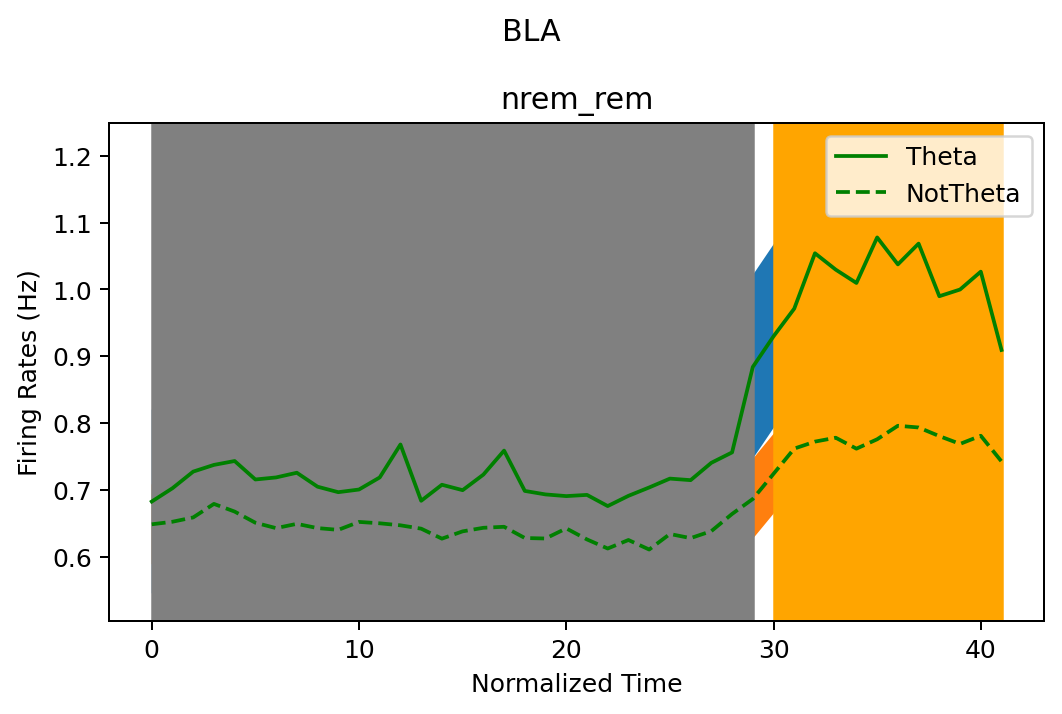

In [54]:
make_figure(nrem_rem_merged, 'BLA',norm='no', intervals_colors=['grey', 'orange'])
plt.legend(['Theta', 'NotTheta'])
plt.savefig('/home/billel/pCloudDrive/IFM/work/Figures/VitefPourJDS/thetanotheta_bla.svg')

a = nrem_rem_merged['metadata']
print(len(a[(a['Region'] == 'BLA') & a['modulated']]))

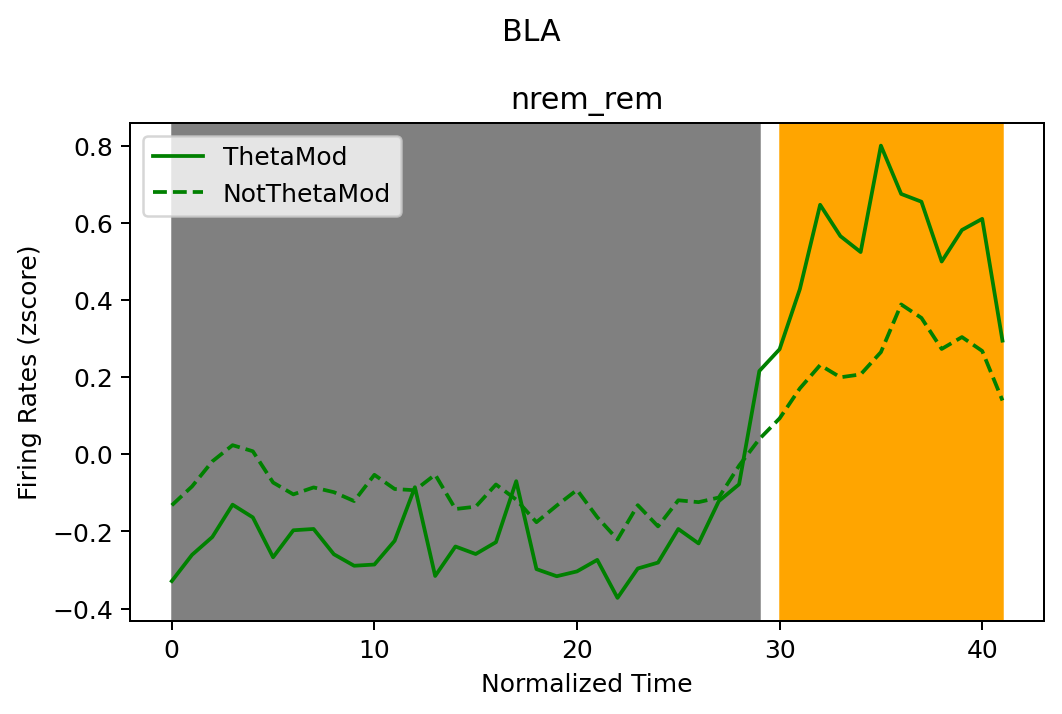

In [214]:
make_figure(nrem_rem_merged, 'BLA', intervals_colors=['grey', 'orange'])
plt.legend(['ThetaMod', 'NotThetaMod'])


In [48]:
import pandas as pd
import numpy as np

import bk.load

bk.load.current_session_linux()
neurons,metadata = bk.load.spikes()
states = bk.load.states()

Rat : 8 on day : 6
Working with session Rat08-20130713 @ /home/billel/Data/GG-Dataset/Rat08/Rat08-20130713
Data already saved in Numpy format, loading them from here:
Rat08-20130713-neurons.npy
Rat08-20130713-metadata.npy


In [49]:
for i,n in enumerate(neurons):
    neurons[i] = n.restrict(states['Rem'])



In [56]:
# Sub sample n spikes 
n_spikes = 10000

for i,n in enumerate(neurons):
    if len(n)>n_spikes:
        neurons[i] = n.times()[[np.random.choice(len(n),n_spikes)]]
    else: neurons[i] = np.nan

TypeError: object of type 'float' has no len()

In [61]:

a = [np.any(np.isnan(n)) for n in neurons]

In [62]:
np.sum(a)

104

In [63]:
PAFC = 5

NameError: name 'PCC' is not defined